In [1]:
import tensorflow as tf

conv_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

c:\users\ni_po\appdata\local\programs\python\python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\ni_po\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\users\ni_po\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


58900480/58889256 [==============================] - 9s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [4]:
import pathlib

mainDir = pathlib.Path().resolve()
original_datasets_dir = os.path.join(mainDir,"data")
original_datasets_dir = os.path.join(original_datasets_dir,"train1")

base_dir = 'data\\cats_and_dogs_small'

original_datasets_dir = os.path.abspath(original_datasets_dir)

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size = batch_size,
        class_mode='binary'
    )
    i = 0
    for input_batch, labels_batch in generator:
        features_batch = conv_base.predict(input_batch)
        features[i* batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i* batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [7]:
from keras import layers, models
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])


c:\users\ni_po\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [8]:
history = model.fit(train_features, 
                    train_labels, 
                    epochs=30, 
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 6s 33ms/step - loss: 0.6147 - acc: 0.6590 - val_loss: 0.4432 - val_acc: 0.8390
Epoch 2/30
100/100 [==============================] - 3s 31ms/step - loss: 0.4433 - acc: 0.7995 - val_loss: 0.3628 - val_acc: 0.8640
Epoch 3/30
100/100 [==============================] - 3s 30ms/step - loss: 0.3506 - acc: 0.8570 - val_loss: 0.3298 - val_acc: 0.8630
Epoch 4/30
100/100 [==============================] - 3s 30ms/step - loss: 0.3200 - acc: 0.8695 - val_loss: 0.2987 - val_acc: 0.8840
Epoch 5/30
100/100 [==============================] - 4s 39ms/step - loss: 0.2762 - acc: 0.8970 - val_loss: 0.2831 - val_acc: 0.8850
Epoch 6/30
100/100 [==============================] - 3s 34ms/step - loss: 0.2605 - acc: 0.9010 - val_loss: 0.2728 - val_acc: 0.8910
Epoch 7/30
100/100 [==============================] - 4s 36ms/step - loss: 0.2429 - acc: 0.9110 - val_loss: 0.2641 - val_acc: 0.8900
Epoch 8/30
100/100 [==============================] - 4s 39ms/step - 

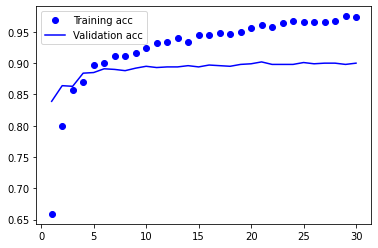

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = "Training acc")
plt.plot(epochs, val_acc, 'b', label = "Validation acc")
plt.legend()

<Figure size 432x288 with 0 Axes>

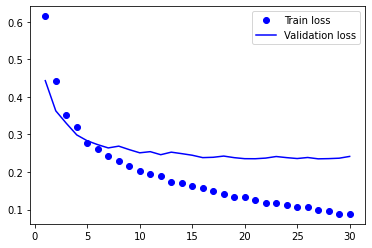

<Figure size 432x288 with 0 Axes>

In [10]:
plt.plot(epochs, loss, 'bo', label='Train loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()
plt.figure()